<a href="https://colab.research.google.com/github/Adam1416k/DT2119_Project/blob/kohei/Multi_scale_Speaker_Diarization_with_Dynamic_Scale_Weighting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=7c265bf3f30bb6a591b6d5f3b2028aca4620bdce203783b9cc74544e57a1776b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base
  libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base
  libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 34 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of ad

In [ ]:
!git clone https://github.com/NVIDIA/NeMo
!wget https://www.robots.ox.ac.uk/~vgg/data/voxconverse/data/voxconverse_dev_wav.zip
!wget https://www.robots.ox.ac.uk/~vgg/data/voxconverse/data/voxconverse_test_wav.zip
!git clone https://github.com/joonson/voxconverse
!unzip voxconverse_dev_wav.zip
!mv audio audio_dev
!unzip voxconverse_test_wav.zip
!mv voxconverse_test_wav audio_test

Cloning into 'NeMo'...
remote: Enumerating objects: 244265, done.
remote: Counting objects: 100% (3005/3005), done.
remote: Compressing objects: 100% (1701/1701), done.
remote: Total 244265 (delta 2016), reused 1312 (delta 1304), pack-reused 241260 (from 5)
Receiving objects: 100% (244265/244265), 458.53 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (182768/182768), done.
--2025-05-12 08:22:48--  https://www.robots.ox.ac.uk/~vgg/data/voxconverse/data/voxconverse_dev_wav.zip
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1988647478 (1.9G) [application/zip]
Saving to: ‘voxconverse_dev_wav.zip’

voxconverse_dev_wav 100%[===================>]   1.85G  16.2MB/s    in 2m 0s   

2025-05-12 08:24:49 (15.8 MB/s) - ‘voxconverse_dev_wav.zip’ saved [1988647478/1988647478]

--2025-05-12 08:24:49--  https://www.robots.ox.ac.uk/~vgg/data/v

# Sample

In [ ]:
import os
import wget
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)
an4_audio = os.path.join(data_dir,'an4_diarize_test.wav')
an4_rttm = os.path.join(data_dir,'an4_diarize_test.rttm')
if not os.path.exists(an4_audio):
    an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
    an4_audio = wget.download(an4_audio_url, data_dir)
if not os.path.exists(an4_rttm):
    an4_rttm_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.rttm"
    an4_rttm = wget.download(an4_rttm_url, data_dir)

['0.299 2.77 A', '3.164 5.147 B']


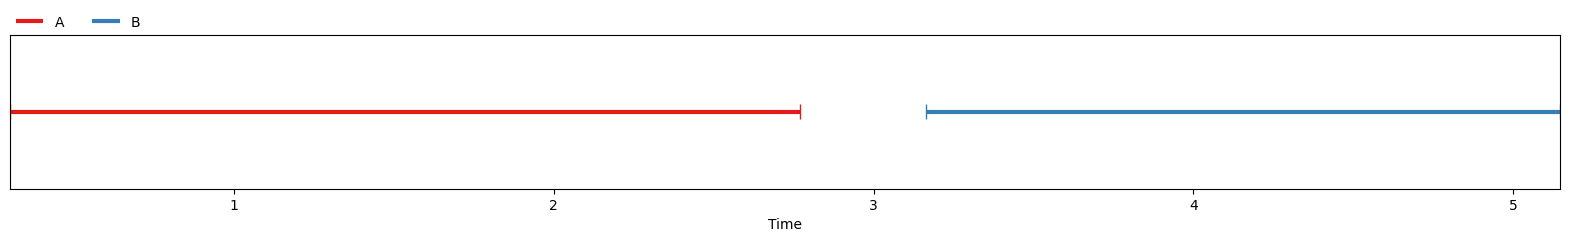

In [ ]:
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object
labels = rttm_to_labels(an4_rttm)
reference = labels_to_pyannote_object(labels)
print(labels)
reference

In [ ]:
# Create a manifest for input with below format.
# {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-',
# 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
import json
meta = {
    'audio_filepath': an4_audio,
    'offset': 0,
    'duration':None,
    'label': 'infer',
    'text': '-',
    'num_speakers': 2,
    'rttm_filepath': an4_rttm,
    'uem_filepath' : None
}
with open('data/input_manifest.json','w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

!cat data/input_manifest.json

output_dir = os.path.join(ROOT, 'oracle_vad')
os.makedirs(output_dir,exist_ok=True)

{"audio_filepath": "/content/data/an4_diarize_test.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": "/content/data/an4_diarize_test.rttm", "uem_filepath": null}


In [ ]:
from omegaconf import OmegaConf
MODEL_CONFIG = os.path.join(data_dir,'diar_infer_telephonic.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/diar_infer_telephonic.yaml"
    MODEL_CONFIG = wget.download(config_url,data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

name: ClusterDiarizer
num_workers: 1
sample_rate: 16000
batch_size: 64
device: null
verbose: true
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: vad_multilingual_marblenet
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.5
      onset: 0.1
      offset: 0.1
      pad_onset: 0.1
      pad_offset: 0
      min_duration_on: 0
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec:
      - 1.5
      - 1.25
      - 1.0
      - 0.75
      - 0.5
      shift_length_in_sec:
      - 0.75
      - 0.625
      - 0.5
      - 0.375
      - 0.25
      multiscale_weights:
      - 1
      - 1
      - 1
      - 1
      - 1
      save_embeddings: true
  clustering:
    parameters:
      oracle_num_speakers: false
      max

In [ ]:
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir # Directory to store intermediate files and prediction outputs
pretrained_speaker_model = 'titanet_large'
config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = [1.5,1.25,1.0,0.75,0.5]
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = [0.75,0.625,0.5,0.375,0.1]
config.diarizer.speaker_embeddings.parameters.multiscale_weights= [1,1,1,1,1]
config.diarizer.oracle_vad = True # ----> ORACLE VAD
config.diarizer.clustering.parameters.oracle_num_speakers = False

In [ ]:
config.diarizer.msdd_model.model_path = 'diar_msdd_telephonic' # Telephonic speaker diarization model
config.diarizer.msdd_model.parameters.sigmoid_threshold = [0.7, 1.0] # Evaluate with T=0.7 and T=1.0

In [ ]:
from nemo.collections.asr.models.msdd_models import NeuralDiarizer
oracle_vad_msdd_model = NeuralDiarizer(cfg=config)

[NeMo I 2025-05-08 13:43:16 nemo_logging:393] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2025-05-08 13:43:16 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/diar_msdd_telephonic/versions/1.0.1/files/diar_msdd_telephonic.nemo to /root/.cache/torch/NeMo/NeMo_2.4.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2025-05-08 13:43:17 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-05-08 13:43:19 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2025-05-08 13:43:19 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2025-05-08 13:43:19 nemo_logging:405] Please call the ModelPT.setup_test_data() or ModelPT

[NeMo I 2025-05-08 13:43:19 nemo_logging:393] PADDING: 16
[NeMo I 2025-05-08 13:43:19 nemo_logging:393] PADDING: 16
[NeMo I 2025-05-08 13:43:20 nemo_logging:393] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2025-05-08 13:43:20 nemo_logging:393] PADDING: 16


In [ ]:
oracle_vad_msdd_model.diarize()

[NeMo I 2025-05-08 13:43:42 nemo_logging:393] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2025-05-08 13:43:42 nemo_logging:393] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }
[NeMo I 2025-05-08 13:43:42 nemo_logging:393] Number of files to diarize: 1
[NeMo I 2025-05-08 13:43:42 nemo_logging:393] Subsegmentation for embedding extraction: scale0, /content/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2025-05-08 13:43:42 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 13:43:42 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 13:43:42 nemo_logging:393] Dataset successfully loaded with 5 items and total duration provided from manifest is  0.00

[1/5] extract embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Saved embedding files to /content/oracle_vad/speaker_outputs/embeddings
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Subsegmentation for embedding extraction: scale1, /content/oracle_vad/speaker_outputs/subsegments_scale1.json
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Dataset successfully loaded with 6 items and total duration provided from manifest is  0.00 hours.
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] # 6 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Saved embedding files to /content/oracle_vad/speaker_outputs/embeddings
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Subsegmentation for embedding extraction: scale2, /content/oracle_vad/speaker_outputs/subsegments_scale2.json
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Dataset successfully loaded with 7 items and total duration provided from manifest is  0.00 hours.
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] # 7 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]

[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Saved embedding files to /content/oracle_vad/speaker_outputs/embeddings
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Subsegmentation for embedding extraction: scale3, /content/oracle_vad/speaker_outputs/subsegments_scale3.json
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] Dataset successfully loaded with 11 items and total duration provided from manifest is  0.00 hours.
[NeMo I 2025-05-08 13:43:43 nemo_logging:393] # 11 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

[NeMo I 2025-05-08 13:43:44 nemo_logging:393] Saved embedding files to /content/oracle_vad/speaker_outputs/embeddings
[NeMo I 2025-05-08 13:43:44 nemo_logging:393] Subsegmentation for embedding extraction: scale4, /content/oracle_vad/speaker_outputs/subsegments_scale4.json
[NeMo I 2025-05-08 13:43:44 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 13:43:44 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 13:43:44 nemo_logging:393] Dataset successfully loaded with 37 items and total duration provided from manifest is  0.01 hours.
[NeMo I 2025-05-08 13:43:44 nemo_logging:393] # 37 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

[NeMo I 2025-05-08 13:43:44 nemo_logging:393] Saved embedding files to /content/oracle_vad/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

[NeMo I 2025-05-08 13:43:45 nemo_logging:393] Outputs are saved in /content/oracle_vad directory
[NeMo I 2025-05-08 13:43:45 nemo_logging:393] 
                     diarization error rate  total correct        false alarm  \
                                          %                     %               
    item                                                                        
    an4_diarize_test                    0.0  3.454   3.454  100.0         0.0   
    TOTAL                               0.0  3.454   3.454  100.0         0.0   
    
                          missed detection      confusion       
                        %                     %              %  
    item                                                        
    an4_diarize_test  0.0              0.0  0.0       0.0  0.0  
    TOTAL             0.0              0.0  0.0       0.0  0.0  
[NeMo I 2025-05-08 13:43:45 nemo_logging:393] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
    | FA: 


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

[NeMo I 2025-05-08 13:43:45 nemo_logging:393]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2025-05-08 13:43:45 nemo_logging:393] Number of files to diarize: 1
[NeMo I 2025-05-08 13:43:45 nemo_logging:393] Number of files to diarize: 1


[NeMo I 2025-05-08 13:43:45 nemo_logging:393] 
                     diarization error rate  total correct        false alarm  \
                                          %                     %               
    item                                                                        
    an4_diarize_test                    0.0  3.454   3.454  100.0         0.0   
    TOTAL                               0.0  3.454   3.454  100.0         0.0   
    
                          missed detection      confusion       
                        %                     %              %  
    item                                                        
    an4_diarize_test  0.0              0.0  0.0       0.0  0.0  
    TOTAL             0.0              0.0  0.0       0.0  0.0  
[NeMo I 2025-05-08 13:43:45 nemo_logging:393] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
    | FA: 0.0000 | MISS: 0.0000 | CER: 0.0000 | DER: 0.0000 | Spk. Count Acc. 1.0000
    
[NeMo I 2025-05-0

[[(<pyannote.metrics.diarization.DiarizationErrorRate at 0x7e958c6a1bd0>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7e958e832e50>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7e958e8844d0>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0017961383026493304,
    0.0,
    0.0015716210148181671,
    0.00022451728783116318))],
 [(<pyannote.metrics.diarization.DiarizationErrorRate at 0x7e95800900d0>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7e95801ad650>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7e9583b7eb10>,
   {'an4_diarize_test': {'speaker_0': 'B', 

In [ ]:
!cat {output_dir}/pred_rttms/an4_diarize_test.rttm

SPEAKER an4_diarize_test 1   0.300   2.470 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER an4_diarize_test 1   3.160   1.990 <NA> <NA> speaker_0 <NA> <NA>


Neural Diarizer Result (RTTM format)


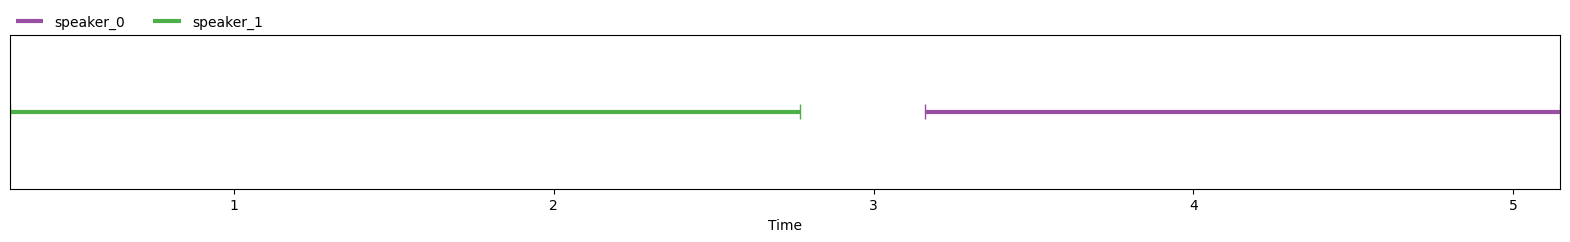

In [ ]:
print("Neural Diarizer Result (RTTM format)")
pred_labels_neural = rttm_to_labels(f'{output_dir}/pred_rttms/an4_diarize_test.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural

Ground-truth Speaker Labels


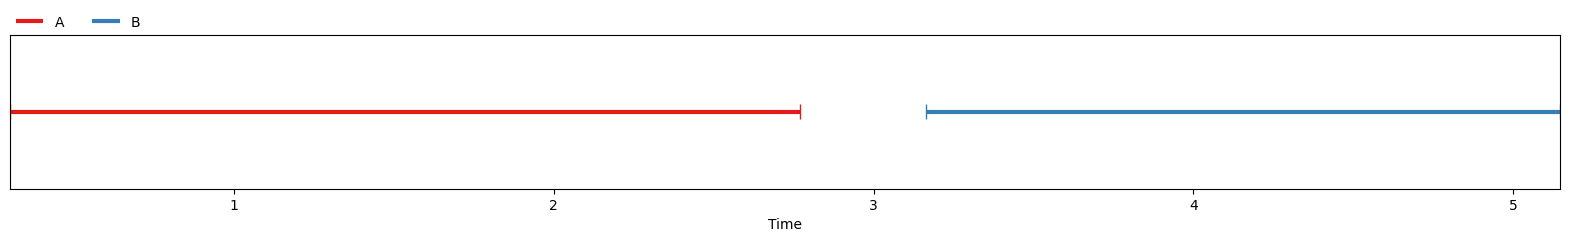

In [ ]:
print("Ground-truth Speaker Labels")
reference

# Voxconverse

In [ ]:
inference_dir = "voxconverse_inference"
os.makedirs(inference_dir,exist_ok=True)

In [ ]:
from pathlib import Path
rttm_dir_test = Path("./voxconverse/test")
audio_dir_test = Path("./audio_test")
rttm_files_test = sorted(rttm_dir_test.rglob("*.rttm"))
wav_files_test = sorted(audio_dir_test.rglob("*.wav"))

print("Total number of files: ", len(rttm_files_test))
select_top = 232
rttm_files_test = rttm_files_test[:select_top]
wav_files_test = wav_files_test[:select_top]
print(f'Select {select_top} files')

Total number of files:  232
Select 232 files


In [ ]:
with open("infer_rttm_file_list.txt", "w") as f:
    for rttm_file in rttm_files_test:
        f.write(str(os.path.abspath(rttm_file)) + "\n")

with open("infer_audio_file_list.txt", "w") as f:
    for wav_file in wav_files_test:
        f.write(str(os.path.abspath(wav_file)) + "\n")

In [ ]:
!python NeMo/scripts/speaker_tasks/pathfiles_to_diarize_manifest.py   --add_duration   --paths2audio_files="./infer_audio_file_list.txt"   --paths2rttm_files="./infer_rttm_file_list.txt" --manifest_filepath="./infer_manifest.json"

In [ ]:
from omegaconf import OmegaConf
MODEL_CONFIG = os.path.join(data_dir,'diar_infer_telephonic.yaml')
# use telephonic inference configuration
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/diar_infer_telephonic.yaml"
    MODEL_CONFIG = wget.download(config_url,data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

In [ ]:
config.diarizer.manifest_filepath = 'infer_manifest.json'
config.diarizer.out_dir = inference_dir # Directory to store intermediate files and prediction outputs
pretrained_speaker_model = 'titanet_large'
config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = [1.5,1.25,1.0,0.75,0.5]
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = [0.75,0.625,0.5,0.375,0.1]
config.diarizer.speaker_embeddings.parameters.multiscale_weights= [1,1,1,1,1]
config.diarizer.oracle_vad = True # ----> ORACLE VAD
config.diarizer.clustering.parameters.oracle_num_speakers = False

In [ ]:
config.diarizer.msdd_model.model_path = 'diar_msdd_telephonic' # Telephonic speaker diarization model
config.diarizer.msdd_model.parameters.sigmoid_threshold = [0.7, 1.0] # Evaluate with T=0.7 and T=1.0

In [ ]:
from nemo.collections.asr.models.msdd_models import NeuralDiarizer
oracle_vad_msdd_model = NeuralDiarizer(cfg=config)

[NeMo I 2025-05-08 14:00:16 nemo_logging:393] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2025-05-08 14:00:16 nemo_logging:393] Found existing object /root/.cache/torch/NeMo/NeMo_2.4.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2025-05-08 14:00:16 nemo_logging:393] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.4.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2025-05-08 14:00:16 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-05-08 14:00:18 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2025-05-08 14:00:18 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2025-05-08 14:00:18 nemo_logging:405] Please call the ModelPT.setup_test_data() or ModelPT

[NeMo I 2025-05-08 14:00:18 nemo_logging:393] PADDING: 16
[NeMo I 2025-05-08 14:00:18 nemo_logging:393] PADDING: 16
[NeMo I 2025-05-08 14:00:19 nemo_logging:393] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2025-05-08 14:00:19 nemo_logging:393] PADDING: 16


In [ ]:
oracle_vad_msdd_model.diarize()

[NeMo I 2025-05-08 14:00:28 nemo_logging:393] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2025-05-08 14:00:28 nemo_logging:393] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 10,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }
[NeMo I 2025-05-08 14:00:28 nemo_logging:393] Number of files to diarize: 232
[NeMo I 2025-05-08 14:00:29 nemo_logging:393] Subsegmentation for embedding extraction: scale0, voxconverse_inference/speaker_outputs/subsegments_scale0.json
[NeMo I 2025-05-08 14:00:32 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 14:00:33 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 14:00:33 nemo_logging:393] Dataset successfully loaded with 181337 items and total duration provided from manifest

[1/5] extract embeddings: 100%|██████████| 2834/2834 [03:22<00:00, 13.97it/s]


[NeMo I 2025-05-08 14:04:02 nemo_logging:393] Saved embedding files to voxconverse_inference/speaker_outputs/embeddings
[NeMo I 2025-05-08 14:04:02 nemo_logging:393] Subsegmentation for embedding extraction: scale1, voxconverse_inference/speaker_outputs/subsegments_scale1.json
[NeMo I 2025-05-08 14:04:05 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 14:04:06 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 14:04:06 nemo_logging:393] Dataset successfully loaded with 218360 items and total duration provided from manifest is  74.52 hours.
[NeMo I 2025-05-08 14:04:06 nemo_logging:393] # 218360 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 3412/3412 [03:27<00:00, 16.41it/s]


[NeMo I 2025-05-08 14:07:41 nemo_logging:393] Saved embedding files to voxconverse_inference/speaker_outputs/embeddings
[NeMo I 2025-05-08 14:07:41 nemo_logging:393] Subsegmentation for embedding extraction: scale2, voxconverse_inference/speaker_outputs/subsegments_scale2.json
[NeMo I 2025-05-08 14:07:44 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 14:07:46 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 14:07:46 nemo_logging:393] Dataset successfully loaded with 274122 items and total duration provided from manifest is  75.16 hours.
[NeMo I 2025-05-08 14:07:46 nemo_logging:393] # 274122 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 4284/4284 [04:12<00:00, 16.94it/s]


[NeMo I 2025-05-08 14:12:09 nemo_logging:393] Saved embedding files to voxconverse_inference/speaker_outputs/embeddings
[NeMo I 2025-05-08 14:12:09 nemo_logging:393] Subsegmentation for embedding extraction: scale3, voxconverse_inference/speaker_outputs/subsegments_scale3.json
[NeMo I 2025-05-08 14:12:13 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 14:12:16 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 14:12:16 nemo_logging:393] Dataset successfully loaded with 367444 items and total duration provided from manifest is  75.84 hours.
[NeMo I 2025-05-08 14:12:16 nemo_logging:393] # 367444 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 5742/5742 [05:19<00:00, 17.96it/s]


[NeMo I 2025-05-08 14:17:49 nemo_logging:393] Saved embedding files to voxconverse_inference/speaker_outputs/embeddings
[NeMo I 2025-05-08 14:17:49 nemo_logging:393] Subsegmentation for embedding extraction: scale4, voxconverse_inference/speaker_outputs/subsegments_scale4.json
[NeMo I 2025-05-08 14:18:05 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-05-08 14:18:14 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-05-08 14:18:14 nemo_logging:393] Dataset successfully loaded with 1355400 items and total duration provided from manifest is  188.06 hours.
[NeMo I 2025-05-08 14:18:14 nemo_logging:393] # 1355400 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 21179/21179 [38:36<00:00,  9.14it/s]


[NeMo I 2025-05-08 14:58:44 nemo_logging:393] Saved embedding files to voxconverse_inference/speaker_outputs/embeddings


clustering: 100%|██████████| 232/232 [15:23<00:00,  3.98s/it]

[NeMo I 2025-05-08 15:14:09 nemo_logging:393] Outputs are saved in /content/voxconverse_inference directory
[NeMo I 2025-05-08 15:14:09 nemo_logging:393] Wrong Spk. Count with uniq_id:...aggyz, Ref: 13, Hyp: 8
[NeMo I 2025-05-08 15:14:09 nemo_logging:393] Wrong Spk. Count with uniq_id:...aiqwk, Ref: 7, Hyp: 2
[NeMo I 2025-05-08 15:14:09 nemo_logging:393] Wrong Spk. Count with uniq_id:...aorju, Ref: 12, Hyp: 2


[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...auzru, Ref: 8, Hyp: 7
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...bidnq, Ref: 11, Hyp: 3
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...bmsyn, Ref: 5, Hyp: 4
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...bpzsc, Ref: 7, Hyp: 2
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...bvqnu, Ref: 9, Hyp: 3
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...byapz, Ref: 15, Hyp: 1
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...cawnd, Ref: 9, Hyp: 2
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...clfcg, Ref: 9, Hyp: 7
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...cqfmj, Ref: 4, Hyp: 2
[NeMo I 2025-05-08 15:14:10 nemo_logging:393] Wrong Spk. Count with uniq_id:...crorm, Ref

100%|██████████| 60/60 [07:30<00:00,  7.52s/it]


[NeMo I 2025-05-08 15:24:59 nemo_logging:393]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2025-05-08 15:24:59 nemo_logging:393] Number of files to diarize: 232
[NeMo I 2025-05-08 15:24:59 nemo_logging:393] Number of files to diarize: 232
[NeMo I 2025-05-08 15:26:12 nemo_logging:393] Wrong Spk. Count with uniq_id:...aggyz, Ref: 13, Hyp: 8
[NeMo I 2025-05-08 15:26:12 nemo_logging:393] Wrong Spk. Count with uniq_id:...aiqwk, Ref: 7, Hyp: 2
[NeMo I 2025-05-08 15:26:12 nemo_logging:393] Wrong Spk. Count with uniq_id:...aorju, Ref: 12, Hyp: 2
[NeMo I 2025-05-08 15:26:12 nemo_logging:393] Wrong Spk. Count with uniq_id:...auzru, Ref: 8, Hyp: 7
[NeMo I 2025-05-08 15:26:12 nemo_logging:393] Wrong Spk. Count with uniq_id:...bidnq, Ref: 11, Hyp: 3
[NeMo I 2025-05-08 15:26:12 nemo_logging:393] Wrong Spk. Count with uniq_id:...bmsyn, Ref: 5, Hyp: 4
[NeMo I 2025-05-08 15:26:12 nemo_logging:393] Wrong Spk. Count with uniq_id:...bpzsc, Ref: 7, Hyp: 2
[NeMo I 2025-05-08 15

[[(<pyannote.metrics.diarization.DiarizationErrorRate at 0x7e954c7a6dd0>,
   {'aepyx': {'speaker_0': 'spk00',
     'speaker_1': 'spk01',
     'speaker_2': 'spk03',
     'speaker_3': 'spk02'},
    'aggyz': {'speaker_0': 'spk03',
     'speaker_1': 'spk02',
     'speaker_2': 'spk05',
     'speaker_3': 'spk00',
     'speaker_4': 'spk10',
     'speaker_5': 'spk12',
     'speaker_6': 'spk06',
     'speaker_7': 'spk04'},
    'aiqwk': {'speaker_0': 'spk00', 'speaker_1': 'spk02'},
    'aorju': {'speaker_0': 'spk03', 'speaker_1': 'spk02'},
    'auzru': {'speaker_0': 'spk01',
     'speaker_1': 'spk02',
     'speaker_2': 'spk03',
     'speaker_3': 'spk07',
     'speaker_4': 'spk00',
     'speaker_5': 'spk06',
     'speaker_6': 'spk05'},
    'bgvvt': {'speaker_0': 'spk01', 'speaker_1': 'spk00'},
    'bidnq': {'speaker_0': 'spk01',
     'speaker_1': 'spk00',
     'speaker_2': 'spk02'},
    'bjruf': {'speaker_0': 'spk01', 'speaker_1': 'spk00'},
    'bmsyn': {'speaker_0': 'spk01',
     'speaker_1': 's

In [ ]:
#rttm_file = "/content/voxconverse/test/aepyx.rttm"
rttm_file = "/content/voxconverse_inference/pred_rttms/aepyx.rttm"
def rttm_to_object(rttm_file):
    labels = rttm_to_labels(rttm_file)
    pyannote_object = labels_to_pyannote_object(labels)
    return pyannote_object

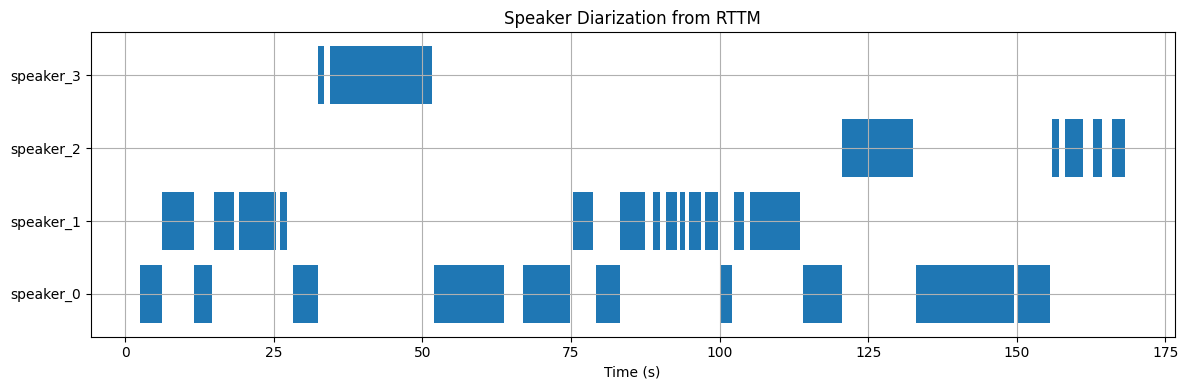

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def load_rttm(file_path):
    return pd.read_csv(
        file_path,
        delim_whitespace=True,
        header=None,
        comment=';',
        names=['type', 'file_id', 'channel', 'start_time', 'duration',
               'ortho', 'stype', 'speaker_id', 'conf', 'slat']
    )


def plot_rttm(df):
    fig, ax = plt.subplots(figsize=(12, 4))

    speaker_set = sorted(df['speaker_id'].unique())
    speaker_map = {spk: i for i, spk in enumerate(speaker_set)}

    for _, row in df.iterrows():
        y = speaker_map[row['speaker_id']]
        ax.broken_barh(
            [(row['start_time'], row['duration'])],
            (y - 0.4, 0.8),
            label=row['speaker_id']
        )

    ax.set_yticks(range(len(speaker_set)))
    ax.set_yticklabels(speaker_set)
    ax.set_xlabel("Time (s)")
    ax.set_title("Speaker Diarization from RTTM")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

df = load_rttm(rttm_file)
plot_rttm(df)

In [ ]:
number = 4
rttm_file_ref = rttm_files_test[number]
rttm_file_infer = Path(inference_dir)/"pred_rttms"/rttm_file_ref.name
print(rttm_file_ref)
print(rttm_file_infer)

voxconverse/test/auzru.rttm
voxconverse_inference/pred_rttms/auzru.rttm


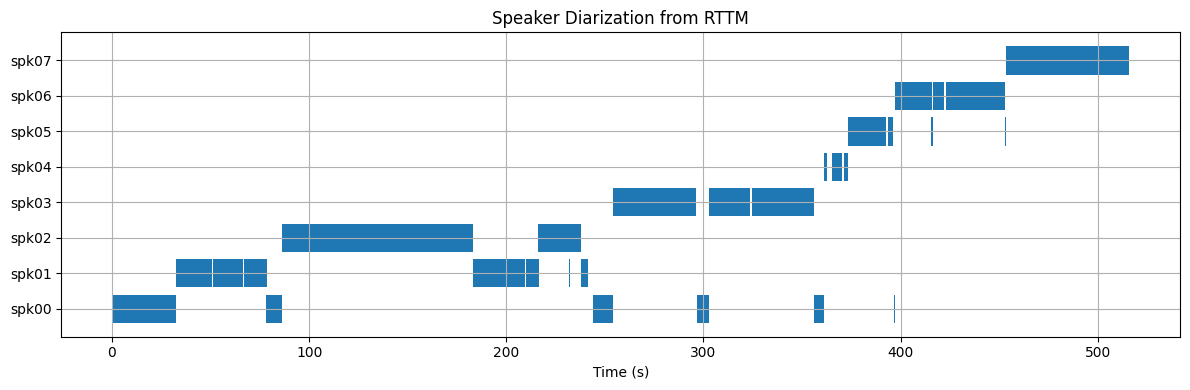

In [ ]:
df = load_rttm(rttm_file_ref)
plot_rttm(df)

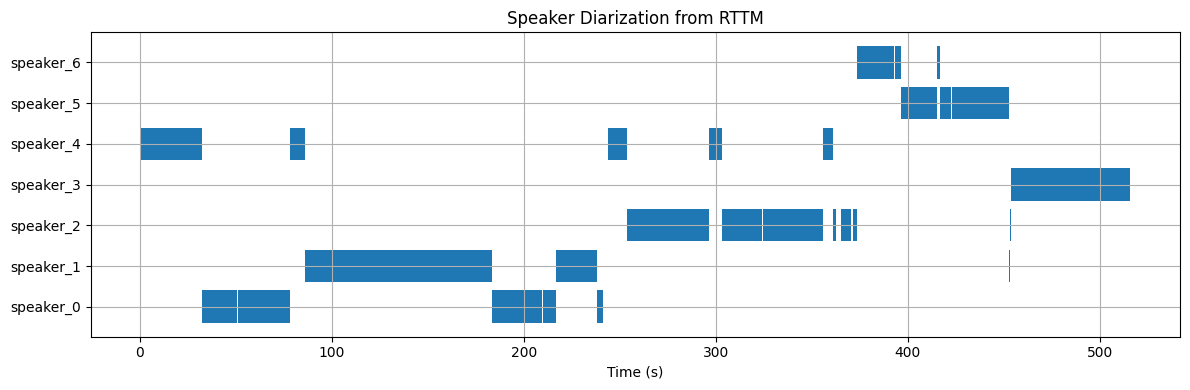

In [ ]:
df = load_rttm(rttm_file_infer)
plot_rttm(df)